# Assessment 3
# Project: Medical Visual-Question Answering
# Group 5

### Anh Hoang Phuc Nguyen - 25178447
### Tri Khang Ho - 25179654


# 1. Import Libraries and Configuration

In [1]:
from datasets import load_dataset
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
import evaluate
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
pd.set_option('display.width', 1000)

In [2]:
PRETRAINED_FLORENCE2 = "microsoft/Florence-2-base-ft"
WEIGHT_FLORENCE2 = "SonicNLP/Florence-2-FT-MedVQA"
DATASET = "SonicNLP/medvqa_dataset"
data = load_dataset(DATASET)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load models

## 2.1 Florence2

In [3]:
code_rev = "refs/pr/6"
base_cfg = AutoConfig.from_pretrained(
    "microsoft/Florence-2-base-ft",
    trust_remote_code=True,
    revision=code_rev,      
)
pretrained_model = AutoModelForCausalLM.from_pretrained(PRETRAINED_FLORENCE2, trust_remote_code=True, revision=code_rev).to(device)
pretrained_processor = AutoProcessor.from_pretrained(PRETRAINED_FLORENCE2, trust_remote_code=True, revision=code_rev)
model = AutoModelForCausalLM.from_pretrained(WEIGHT_FLORENCE2, trust_remote_code=True, config=base_cfg).to(device)
processor = AutoProcessor.from_pretrained(WEIGHT_FLORENCE2, trust_remote_code=True)

/home/phucnah/miniconda3/envs/nlp/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTra

# 3. Evaluation

## 3.1 Metrics

In [4]:
def compute_metrics(predictions, references, use_bertscore=False):
    # Load evaluation metrics
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")
    bertscore = evaluate.load("bertscore") if use_bertscore else None

    # --- ROUGE ---
    rouge_result = rouge.compute(predictions=predictions, references=references)

    # --- BLEU ---
    bleu_result = bleu.compute(predictions=predictions, references=references)

    # --- METEOR ---
    meteor_result = meteor.compute(predictions=predictions, references=references)

    # --- BERTScore (optional) ---
    avg_f1 = None
    if use_bertscore:
        bert_result = bertscore.compute(predictions=predictions, references=references, lang="en")
        avg_f1 = sum(bert_result["f1"]) / len(bert_result["f1"])

    return {
        "rouge": rouge_result,
        "bleu": bleu_result,
        "meteor": meteor_result,
        "bertscore": bert_result,
    }

## 3.2 Before and After fine-tuning Florence2

In [5]:
pretrained_predictions = []
predictions = []
references = []
for idx in tqdm(range(len(data['test']))):
    question = data['test'][idx]['question']
    image = data['test'][idx]['image']
    ground_truth_answers = data['test'][idx]['answers']

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text="<VQA>" + question, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task="<VQA>", image_size=(image.width, image.height))
    predictions.append(parsed_answer['<VQA>'])

    generated_ids = pretrained_model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = pretrained_processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = pretrained_processor.post_process_generation(generated_text, task="<VQA>", image_size=(image.width, image.height))

    pretrained_predictions.append(parsed_answer['<VQA>'])
    references.append(ground_truth_answers[0])  # Assuming the first answer is the reference

# Compute and print evaluation metrics
pretrained_results = compute_metrics(pretrained_predictions, references, use_bertscore=True)
results = compute_metrics(predictions, references, use_bertscore=True)

result_df = {
    "Model": ["Pretrained Florence2", "Fine-tuned Florence2"],
    "ROUGE-1": [pretrained_results["rouge"]["rouge1"], results["rouge"]["rouge1"]],
    "ROUGE-2": [pretrained_results["rouge"]["rouge2"], results["rouge"]["rouge2"]],
    "ROUGE-L": [pretrained_results["rouge"]["rougeL"], results["rouge"]["rougeL"]],
    "BLEU": [pretrained_results["bleu"]["bleu"], results["bleu"]["bleu"]],
    "METEOR": [pretrained_results["meteor"]["meteor"], results["meteor"]["meteor"]],
    "BERTScore": [sum(pretrained_results["bertscore"]["f1"]) / len(pretrained_results["bertscore"]["f1"]),
                  sum(results["bertscore"]["f1"]) / len(results["bertscore"]["f1"])]
}
result_df = pd.DataFrame(result_df, index=None)
print(result_df)

  0%|          | 0/500 [00:00<?, ?it/s]

[nltk_data] Downloading package wordnet to /home/phucnah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/phucnah/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/phucnah/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[nltk_data] Downloading package wordnet to /home/phucnah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/phucnah/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/phuc

                  Model  ROUGE-1   ROUGE-2   ROUGE-L     BLEU    METEOR  BERTScore
0  Pretrained Florence2  0.05600  0.000000  0.056000  0.00000  0.027690   0.828502
1  Fine-tuned Florence2  0.61653  0.214359  0.617805  0.46954  0.411999   0.933230


# 4. Demo

## 4.1 Florence2

In [6]:
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input
    print("Prompt:", prompt)

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")
    
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


Prompt: <VQA>was the mri taken with contrast?
Prediction:  {'<VQA>': 'no'}
Ground Truth Answers: ['no']


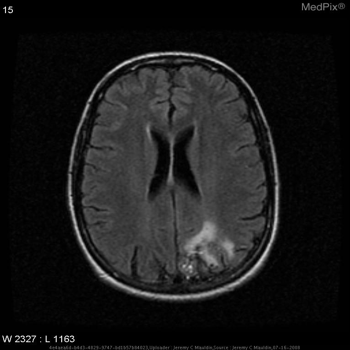

Prompt: <VQA>what is the mr weighting in this image?
Prediction:  {'<VQA>': 't2'}
Ground Truth Answers: ['t2']


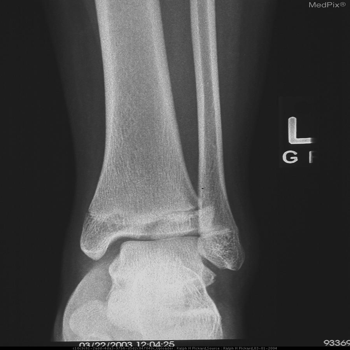

Prompt: <VQA>what type of contrast did this patient have?
Prediction:  {'<VQA>': 'gi and iv'}
Ground Truth Answers: ['gi and iv']


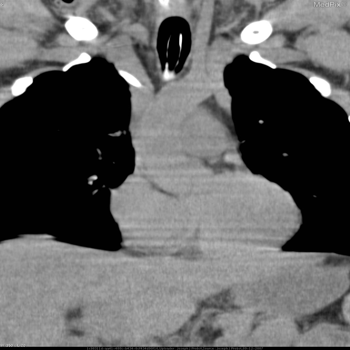

Prompt: <VQA>what type of imaging is this?
Prediction:  {'<VQA>': 'xr - plain film'}
Ground Truth Answers: ['xr - plain film']


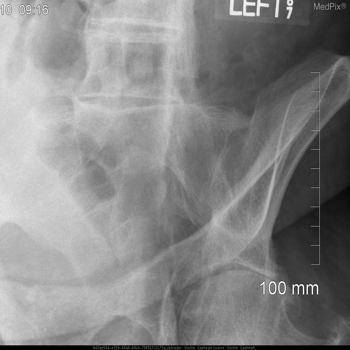

Prompt: <VQA>was the ct scan taken with contrast?
Prediction:  {'<VQA>': 'yes'}
Ground Truth Answers: ['yes']


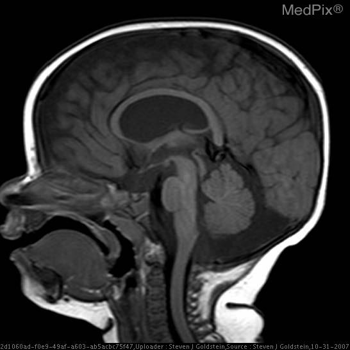

In [10]:
for idx in [1, 5, 7, 16, 21]:
    print("Prediction: ", run_example("<VQA>", data['test'][idx]['question'], data['test'][idx]['image']))
    print("Ground Truth Answers:", data['test'][idx]['answers'])
    display(data['train'][idx]['image'].resize([350, 350]))